# STAT 509 Homework 6
## Brian de Silva

## Problem 1

In [1]:
# Part (f)
x0 = 3
a = x0 + 1
b = 5

# Get P(lambda < 0.5 | x0 = 3):
cat("P(lambda < 0.5 | x0 = 3) = ",pgamma(0.5,shape=a,rate=b),"\n")

# Check answer in (d), i.e. 
cat("P(lambda < 0.5 | x0 = 0) = ",pgamma(0.5,shape=1,rate=5),"\n")
cat("Analytic answer from (d) = ",exp(-5/2),"\n")

P(lambda < 0.5 | x0 = 3) =  0.2424239 
P(lambda < 0.5 | x0 = 0) =  0.917915 
Analytic answer from (d) =  0.082085 


In [2]:
# Part (e)

# Find posterior median for x0 = 3
cat("Posterior median for x0 = 3: ",qgamma(0.5,shape=a,rate=b),"\n")

# Find 95% posterior credible interval for x0 = 3
cat("95% posterior credible interval for x0 = 3: [",
	qgamma(0.025,shape=a,rate=b)," , ",qgamma(0.975,shape=a,rate=b),"]\n")

Posterior median for x0 = 3:  0.7344121 
95% posterior credible interval for x0 = 3: [ 0.2179731  ,  1.753455 ]


## Problem 4

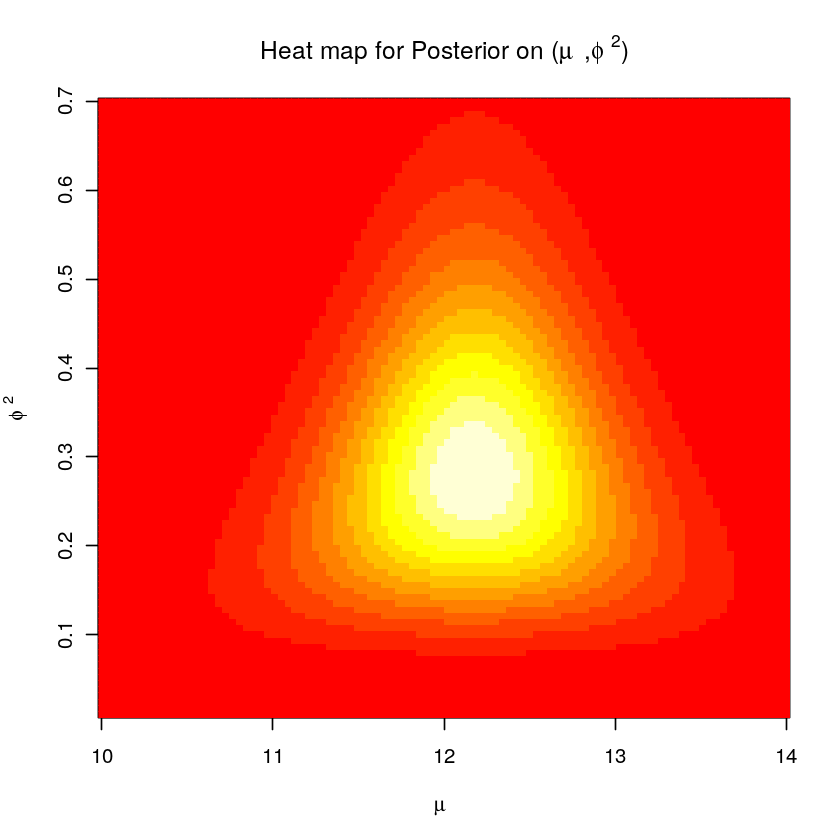

In [3]:
# 
# Part (a): Discrete approximation
# 

# Prior parameters for mu ~ N(mu0,1 / tau20)
mu0 = 10			# Mean of prior 
tau20 = 0.01		# Inverse of variance for prior

# Prior parameters for phi2 ~ Gamma(nu0/2, nu0/(2*phi20))
nu0 = 1
phi20 = 1

# Data (observations)
y = c(8.37, 9.95, 10.89, 12.39, 12.81, 12.93, 13.37, 13.39, 13.51, 14.24)
mean.y = mean(y)
var.y = var(y)
n = length(y)

# Make a grid of values to sample
G = 100
H = 100

mu.grid = seq(10,14,length=G)
phi2.grid = seq(0.01,0.7,length=H)

posterior.grid = matrix(nrow=G,ncol=H)		# Create array in which to store posterior
for(g in 1:G){
	for(h in 1:H){
		posterior.grid[g,h] = 
		dnorm(mu.grid[g],mu0,1/sqrt(tau20)) * 					# p(mu)
		dgamma(phi2.grid[h],nu0/2,nu0/(2*phi20)) * 					# p(phi2)
		prod(dnorm(y,mu.grid[g],1/sqrt(phi2.grid[h])))			# p(y|mu,phi2)
	}
}

posterior.grid = posterior.grid / sum(posterior.grid)		# Normalize

# Heat-map of discrete approximation to joint posterior
image(mu.grid,phi2.grid,posterior.grid,
main=expression(paste("Heat map for Posterior on (", mu, ",", phi^2, ")")),
xlab=expression(mu),ylab=expression(phi^2))

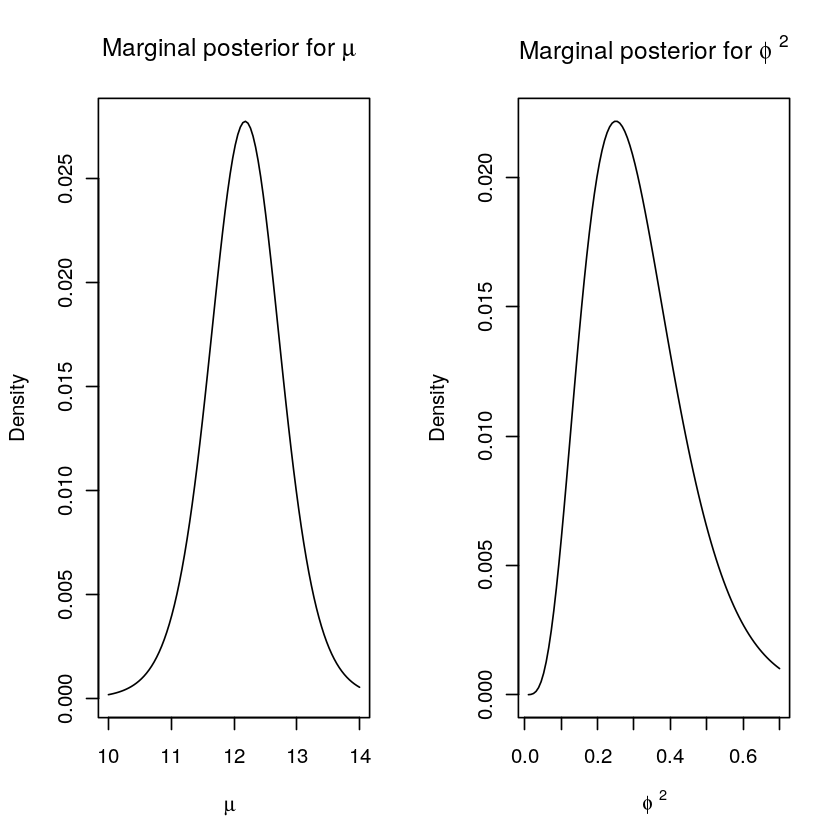

In [4]:
# Compute marginal posteriors for mu and phi2
posterior.mu = rowSums(posterior.grid)
posterior.phi2 = colSums(posterior.grid)

# Plot the approximate marginal posteriors
par(mfrow=c(1,2))
plot(mu.grid,posterior.mu,type="l",
	main=expression(paste("Marginal posterior for ", mu)),
	xlab=expression(mu),ylab="Density")
plot(phi2.grid,posterior.phi2,type="l",
	main=expression(paste("Marginal posterior for ", phi^2)),
	xlab=expression(phi^2),ylab="Density")

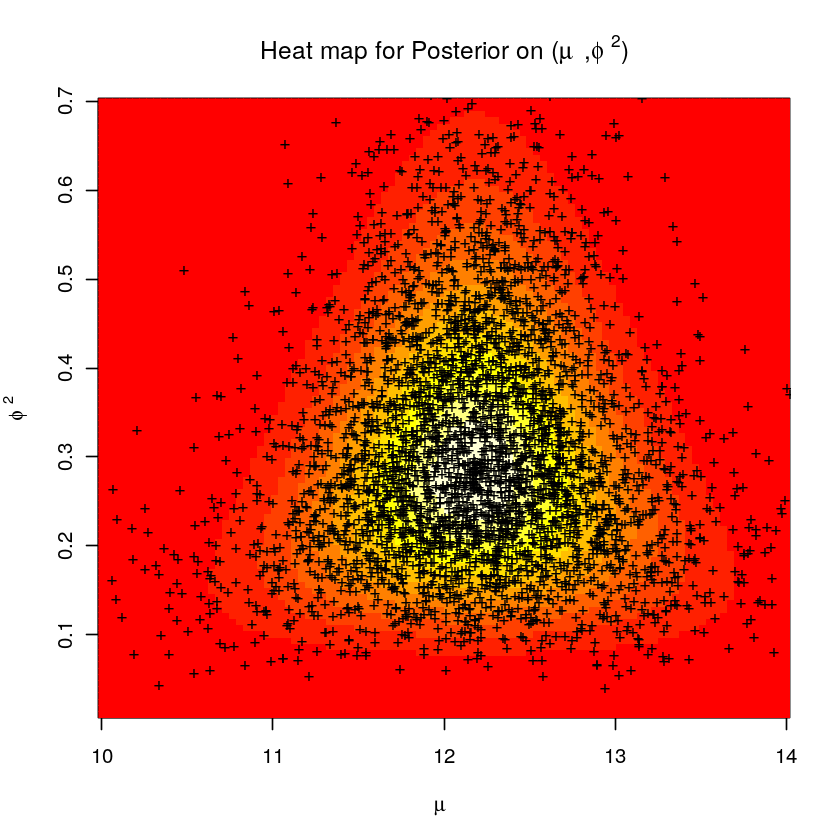

In [5]:
# 
# Part (b): Gibbs sampling
# 

# Chain length
S = 4000
samples = matrix(nrow=S,ncol=2)		# Store S size-2 samples (mu,phi^2)

# Starting values
samples[1,] = c(mean.y,1/var.y)

set.seed(1)							# So that results are reproducible

# Perform the sampling

aStar = (nu0 + n) / 2				# Precompute aStar so we don't re-do work every iteration
var.y.prod = (n-1) * var.y 			# Precompute this term too
for(s in 2:S){

	# Generate new value of mu from f(mu | phi2_prev, data) with random sampling
	prev.phi2 = samples[s-1,2]
	muStar = (mu0 * tau20 + mean.y * n * prev.phi2) / (tau20 + n * prev.phi2)
	phi2Star = tau20 + n * prev.phi2
	mu.new = rnorm(1,muStar,1/sqrt(phi2Star))

	# Generate a new value of phi2 from f(phi2 | mu.new, data)
	bStar = (nu0 / phi20 + var.y.prod + n * (mean.y - mu.new)^2) / 2
	phi2.new = rgamma(1,aStar,bStar)
	samples[s,] = c(mu.new,phi2.new)
}

# Make a scatterplot of the results of the sampling
image(mu.grid,phi2.grid,posterior.grid,
	main=expression(paste("Heat map for Posterior on (", mu, ",", phi^2, ")")),
	xlab=expression(mu),ylab=expression(phi^2))
points(samples[,1],samples[,2],pch="+")

Quantiles for p(mu | data): 


2.5%      50%    97.5% 
10.90719 12.18704 13.43042

Quantiles for p(phi^2 | data): 


2.5%        50%      97.5% 
0.09951989 0.28751382 0.64220160

Quantiles for p(sigma | data): 


2.5%      50%    97.5% 
1.247856 1.864965 3.169897

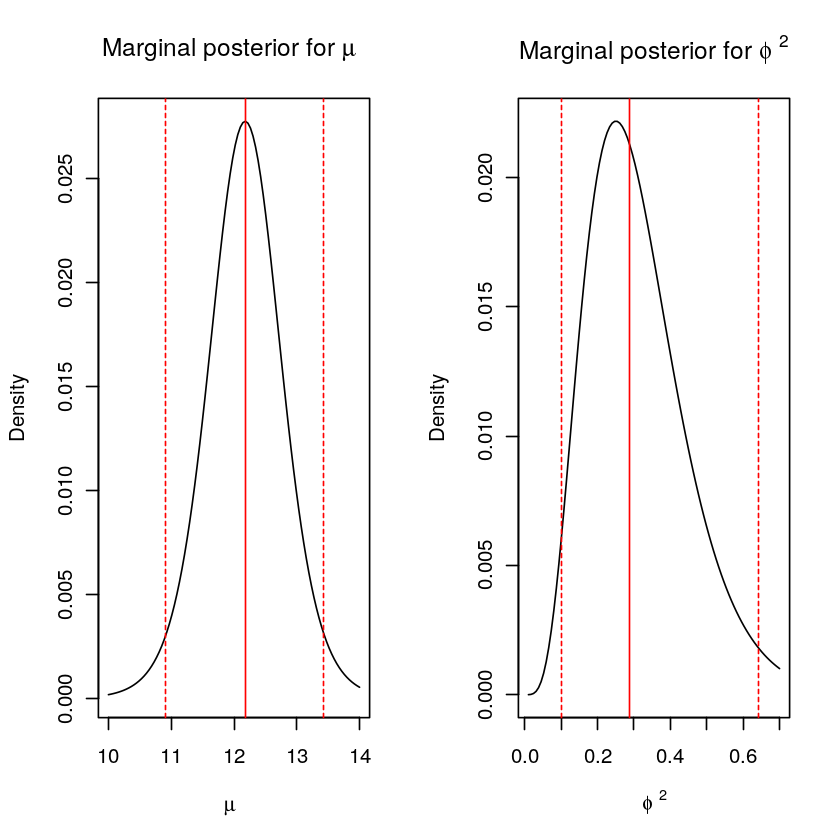

In [7]:
# Compute quantiles for p(mu | data) and p(phi^2 | data)
cat("Quantiles for p(mu | data): \n")
quantile(samples[,1],c(0.025,0.5,0.975))		# mu

cat("Quantiles for p(phi^2 | data): \n")
quantile(samples[,2],c(0.025,0.5,0.975))		# phi^2

# Plot the quantiles
par(mfrow=c(1, 2))
plot(mu.grid,posterior.mu,type="l",
	main=expression(paste("Marginal posterior for ", mu)),
	xlab=expression(mu),ylab="Density")
abline(v=quantile(samples[,1],0.025),col="red",lty=2)
abline(v=quantile(samples[,1],0.975),col="red",lty=2)
abline(v=quantile(samples[,1],0.5),col="red")

plot(phi2.grid,posterior.phi2,type="l",
	main=expression(paste("Marginal posterior for ", phi^2)),
	xlab=expression(phi^2),ylab="Density")
abline(v=quantile(samples[,2],0.025),col="red",lty=2)
abline(v=quantile(samples[,2],0.975),col="red",lty=2)
abline(v=quantile(samples[,2],0.5),col="red")

# Compute quantiles for p(sigma | data)
cat("Quantiles for p(sigma | data): \n")
quantile(1/sqrt(samples[,2]),c(0.025,0.5,0.975))